# Exemples d'utilisation de la librairie

## Récupérer un dataset

- Pour pouvoir utiliser un dataset il faut le placer dans le dossier parent **data/**
- Nous utilisons pour récupérer les dataset la fonction **ImageFolder** de pytorch. Cette fonction nécessite que le dossier de dataset contienne un dossier qui contient les images et non pas les images directement.
- Exemple : **data/celeba/celebaImages/xxxx.png** fonctionne
- Le script **dataset.sh** s'occupe de télécharger les dataset utilisés et les stocker de la bonne façon.

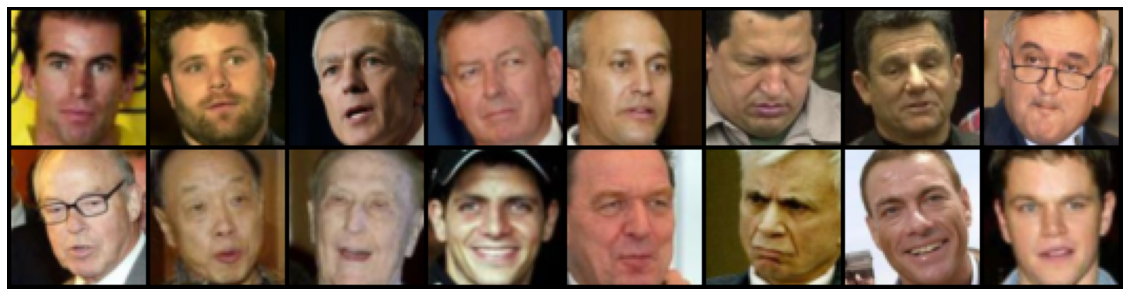

In [1]:
import impaintingLib as imp
from torch.utils.data import DataLoader
import torch

dataset = imp.data.getDataset("./data/lfw") # Récupération du dataset
dataloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=True) # Transformation en dataloader, ce qui permet d'itérer sur les data
x,_  = next(iter(dataloader)) # On itére en général sur un dataloader avec une boucle pour récupérer des batch (de taille batch_size) mais on peut aussi récupérer seulement le premier batch comme ici
imp.utils.plot_img(x) # Affichage du premier batch

Si on n'a pas besoin de tous les batch (par exemple pour tester) on peut récupérer seulement le premier batch directement sans passer par un dataloader

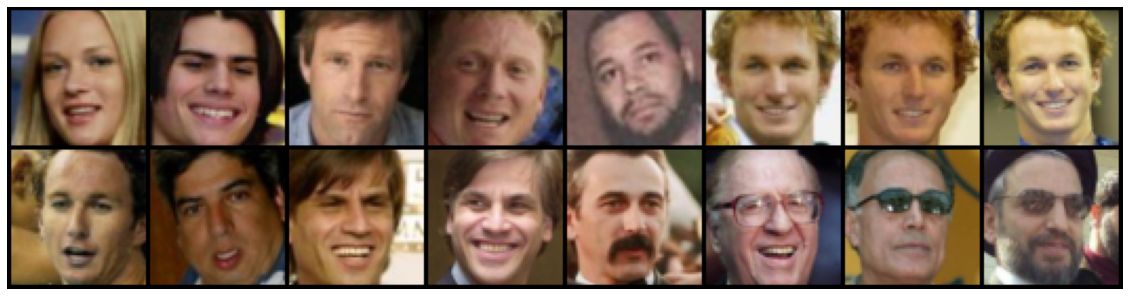

In [2]:
x = imp.data.getTestImages("./data/lfw")
imp.utils.plot_img(x)

- Un crop et un resize sont réalisé par défaut pour zoomer sur les visages et les mettres à la bonne taille mais ces paramètres peuvent être modifiés
- Les images sont par défaut en 64x64 mais leur taille peut être modifié avec **factorResize**, la taille sera alors (64x64) multiplié par **factorResize**

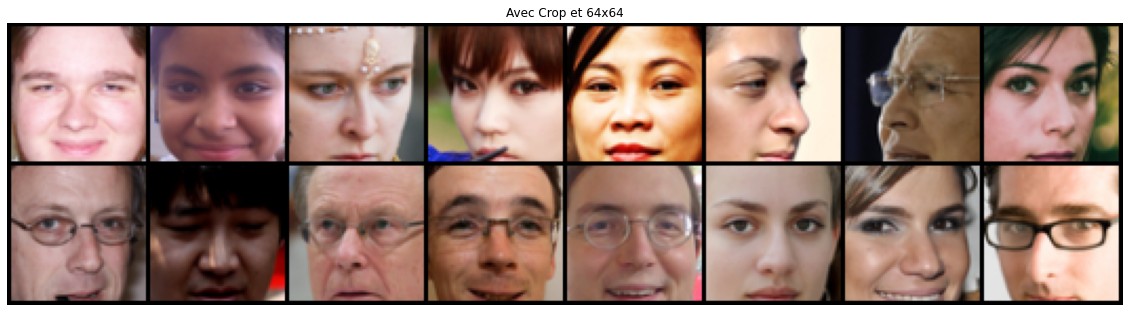

Taille du batch :  torch.Size([16, 3, 64, 64])


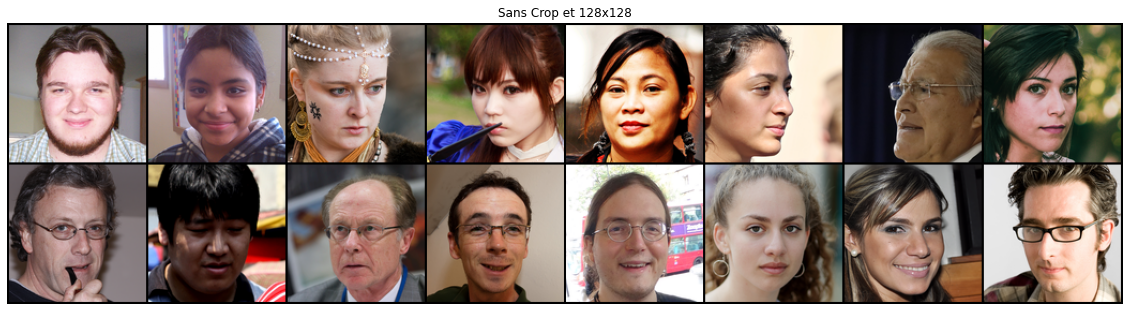

Taille du batch :  torch.Size([16, 3, 128, 128])
----
16 correspond à la taille du batch
3 au nombre de channel des images (3 pour RGB et 1 pour noir et blanc)
128,128 correspondent à la largeur et hauteur des images


In [3]:
x = imp.data.getTestImages("./data/flickr", factorResize=1)
imp.utils.plot_img(x,title="Avec Crop et 64x64")
print("Taille du batch : ",x.shape)

x = imp.data.getTestImages("./data/flickr", doCrop=False, factorResize=2)
imp.utils.plot_img(x,title="Sans Crop et 128x128")
print("Taille du batch : ",x.shape)
print("----")
print(f"{x.shape[0]} correspond à la taille du batch")
print(f"{x.shape[1]} au nombre de channel des images (3 pour RGB et 1 pour noir et blanc)")
print(f"{x.shape[2]},{x.shape[3]} correspondent à la largeur et hauteur des images")

# Application de masque

Il y a 2 types de masques sont disponibles avec la librairie : 
- Les masques carrés (2 carrés de taille aléatoire à des positions aléatoires)
- Les masques irrégulier (des images générés par nvidia qui sont un peu plus naturelles mais aussi plus gourmandes en temps de calcul)

Pour les utiliser on emploi la classe **Alter**. C'est un peu plus compliqué que juste utiliser les fonctions mais ça permet de stocker des informations et de reboucler sur les premiers masques si notre nombre de masque irrégulier est inférieur à notre nombre d'image dans notre dataset (ce qui arrive tout le temps)

Device de x par défaut :  cpu
Device de x après modification :  cuda:0


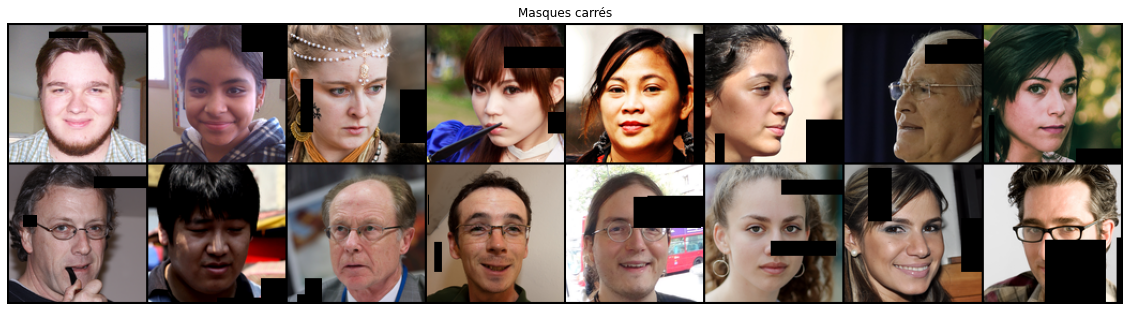

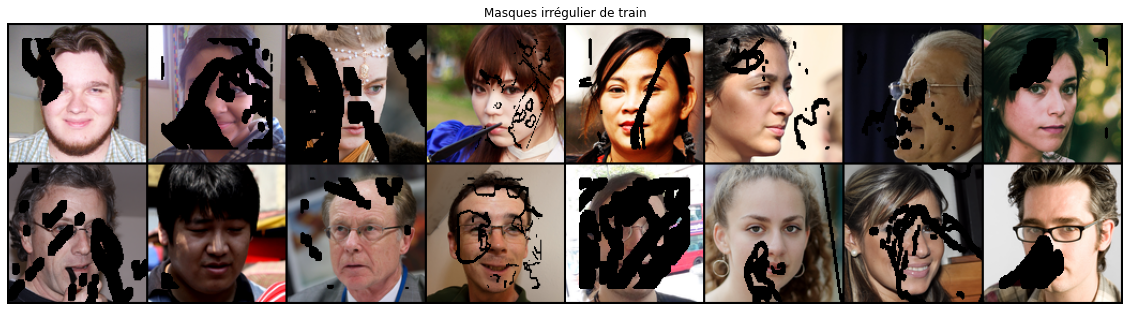

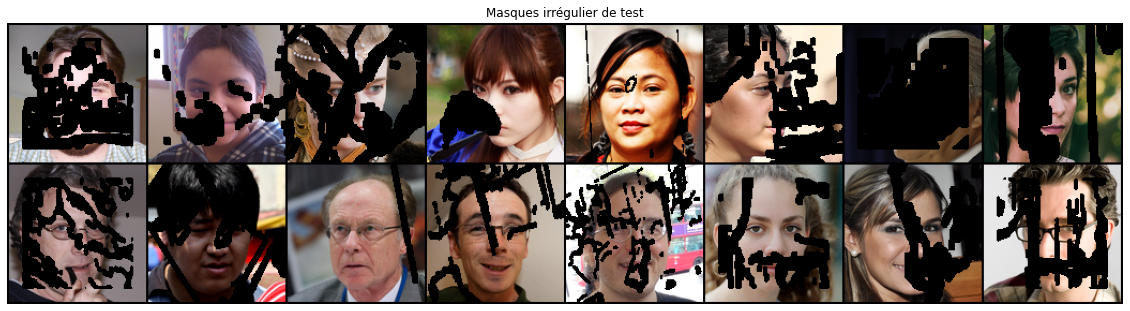

In [4]:
# Quand on modifie des images il est important de les mettre sur le GPU pour ue ça aille plus vite
# Il peut aussi y avoir des bugs si les masques/réseaux et les images ne sont pas sur la même device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device de x par défaut : ",x.device)
x = x.to(device)
print("Device de x après modification : ",x.device)

# Seed permet d'avoir des résultats déterministe. 
# Si la seed est 0 alors les masques seront mélangés aléatoirement mais si la seed est != 0 alors ce sera toujours le même ordre
seed = 1 
factorResize = 2 # Le paramètre resize doit être le même que celui des images

alter = imp.mask.Alter(resize=factorResize,seed=seed).squareMask
x_prime = alter(x)
imp.utils.plot_img(x_prime,title="Masques carrés")

# test=True utilsera les masques test qui sont plus gros que ceux de training (mais quand même utilisable pour le training)
alter = imp.mask.Alter(resize=factorResize,seed=seed).irregularMask
x_prime = alter(x)
imp.utils.plot_img(x_prime,title="Masques irrégulier de train")

alter = imp.mask.Alter(resize=factorResize,seed=seed,test=True).irregularMask
x_prime = alter(x)
imp.utils.plot_img(x_prime,title="Masques irrégulier de test")

## Application de la segmentation

Nous avons utilisé pour notre modèle un réseau de classification (segmentation) qui reconnait les parties d'un visage et leur assigne des valeurs sur une nouvelle couche
Elle permet de donner des informations supplémentaire à notre modèle et l'aide à savoir quoi reconstruire.

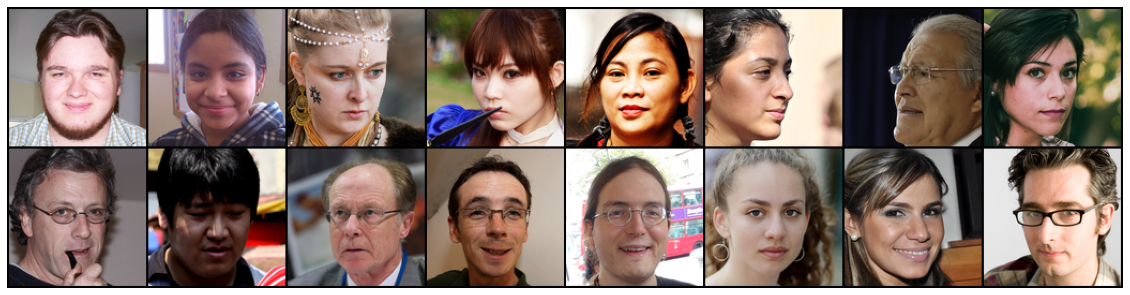

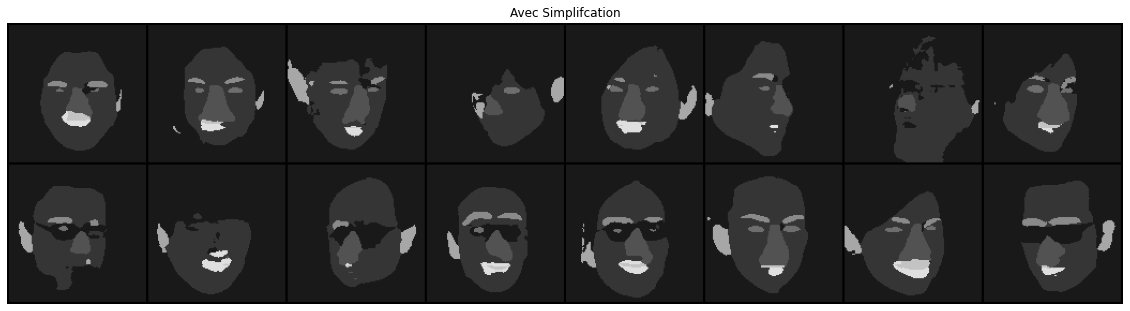

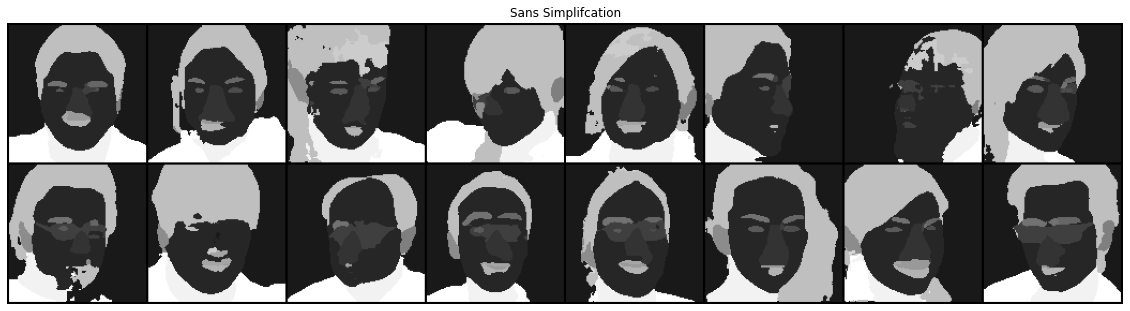

Shape : torch.Size([16, 1, 128, 128])


In [5]:
# La simplification enlève les zones qu'on a jugé inutiles (cheveux, lunettes, habits...) et fusionne les doublons (oeil gauche / oeil droit)
# Le scale_factor est en fonction du factorResize. Le but est de re-multiplier encore la taille de l'image par scale_factor pour l'amener à 256x256 et avoir une meilleure segmentation
# Pour un factorResize=1 il faudra un scale_factor de 4 (64x64) x 1 x 4 = 256
# et pour factorResize=2 il faudra un scale_factor de 2
# Un scale_factor différent de 2 ou 4 a donné de moins bons résultats pour l'instant
segmentation = imp.components.get_segmentation(x, simplify=True, scale_factor=2)
imp.utils.plot_img(x)
imp.utils.plot_img(segmentation,title="Avec Simplifcation")
segmentation = imp.components.get_segmentation(x, simplify=False, scale_factor=2)
imp.utils.plot_img(segmentation,title="Sans Simplifcation")
print("Shape :",segmentation.shape)

## Application des keypoints

De la même façon que la segmentation, les keypoints rajoutent des informations et permettent au modèle de savoir où sont les zonnes principale du visage

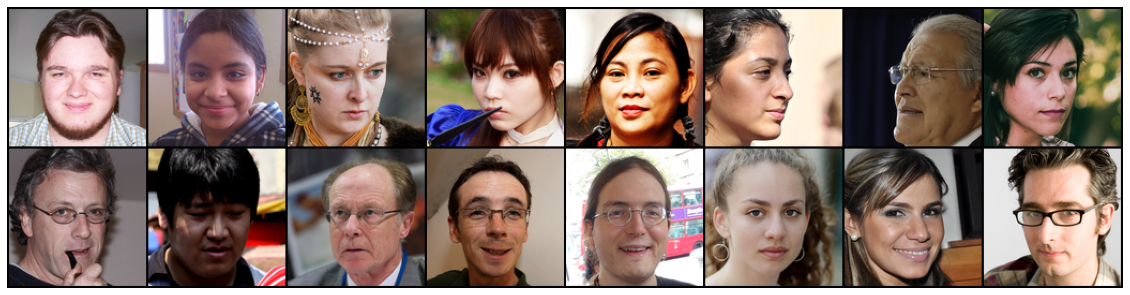

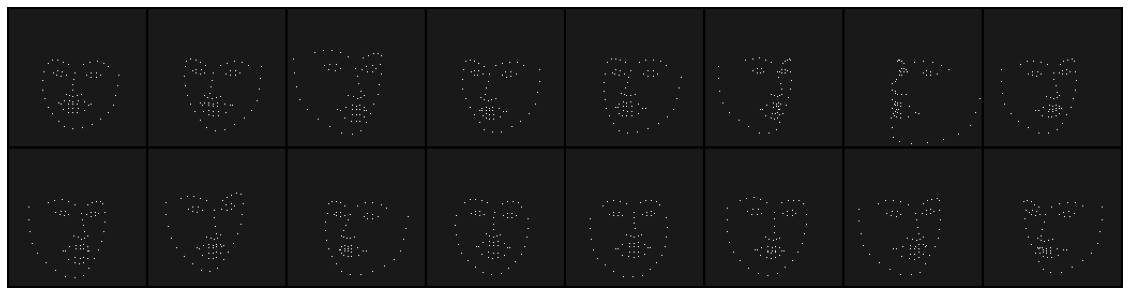

Shape : torch.Size([16, 1, 128, 128])


In [6]:
keypoints = imp.components.getKeypoints(x)
imp.utils.plot_img(x)
imp.utils.plot_img(keypoints)
print("Shape :",keypoints.shape)

## Concaténation des informations

Nous avons pour l'instant : 
- Les images altérés (sur 3 channels)
- La segmentation (sur 1 channel)
- Les keypoints (sur 1 channel)

Avant des les passer au modèle il faut cependant les concaténer afin d'obtenir des data sur 5 channels

In [7]:
segmented = imp.components.get_segmentation(x, simplify=True, scale_factor=2)
x_prime = alter(x)
x_input = torch.cat((x_prime, segmented),dim=1)
keypointLayer = imp.components.getKeypoints(x)
x_input = torch.cat((x_input, keypointLayer),dim=1)

print("X : ", x.shape)
print("Seg : ", segmented.shape)
print("Keypoints : ", keypoints.shape)
print("Final data : ", x_input.shape)

X :  torch.Size([16, 3, 128, 128])
Seg :  torch.Size([16, 1, 128, 128])
Keypoints :  torch.Size([16, 1, 128, 128])
Final data :  torch.Size([16, 5, 128, 128])


## Création du modèle

Différents modèles sont déjà disponibles dans la librairie mais il est toujours possible d'en ajouter de nouveaux
Actuellement implémentés : 
- UNet (avec différentes convolutions)
- AutoEncoder (un Unet en moins poussé)
- SubpixelNetwork (= pixelShuffle)
- ClassifierUNet (pour la segmentation)
- XceptionNet (pour les keypoints)
- RRDBNet (pour la super résolution)

In [3]:
model = imp.model.UNet(5, netType="partial").to(device) 
#model = imp.model.AutoEncoder(5).to(device)
#model = imp.model.SubPixelNetwork(5).to(device)

# On crée ensuite un optimizer correspondant au modèle
# Il n'y a pas besoin de beaucoup y toucher mis à part le learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)

Le learning rate ici peut être ajusté au fur et à mesure des epochs avec un **Scheduler** mais il sera présenté dans ce notebook plus tard (dans la partie training)

## Sauver et récupérer les poids d'un réseau

Pour éviter de repartir de 0 à chaque fois il est possible de sauvegarder les poids à la fin d'un entrainement pour les utiliser plus tard

In [4]:
#torch.save(model.state_dict(),"modelSave/modelSaved") # Sauvegarde le modèle dans le dossier modelSave
model.load_state_dict(torch.load("modelSave/24_08/bigRun215")) # Récupère les poids pour que le réseau retrouve son état sauvegardé

<All keys matched successfully>

## Les différentes loss

Plusieurs loss sont implémentés dans la librairie :
- keypointLoss
- totalVariation
- perceptualVGG
- perceptualAE 
- perceptualClassifier

## Les convolutions

Les convolutions implémentés se trouvent dans le dossier **impaintingLib/model/layer**. Elles sont déjà implémentés dans le model UNet et peuvent être choisi grâce à un paramètre.
Pour l'instant il y a : 
- Convolution partielle
- Gated convolution

## Tensorboard

Pour monitorer l'évolution d'une loss ou de résultats lors d'une run il peut être intéressant d'utiliser tensorboard.
Tensorboard est installé par défaut sur les serveurs du CNRS.

In [ ]:
runName = "testTensorboard" # important de donner des noms différents aux run pour pas que les données se mélangent
writer = SummaryWriter("runs/" + runName)
writer.add_image("Image Originale",make_grid(x[:8]))
writer.close()

## Training usuel

## Training GAN

Le GAN est une des pistes que l'on a commencé à creuser mais comme c'est compliqué de bien entrainer un GAN on a laissé ça de côté au profit des modèles de diffusion qui avaient l'air plus stables

In [12]:
import impaintingLib as imp 
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from statistics import mean

def train_inpainting_segmented_keypoints_GAN(net, g_optimizer, discriminator, d_optimizer, loader, alter, runName,scale_factor=4, epochs=5, simplify_seg=True, show_images=True):
    
    net.train()
    for epoch in range(epochs):
        running_loss = []
        running_loss_gan = []
        running_sr_gen = []
        running_sr_real = []
        
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            segmented = imp.components.get_segmentation(x, simplify=simplify_seg, scale_factor=scale_factor)
            x_prime = alter(x)
            x_input = torch.cat((x_prime, segmented),dim=1)
            keypointLayer = imp.components.getKeypoints(x)
            x_input = torch.cat((x_input, keypointLayer),dim=1)
        
            outputs = net(x_input)
            
            loss = 0
            loss += torch.nn.L1Loss()(outputs, x)
            loss += imp.loss.perceptualVGG(outputs, x)
            loss += imp.loss.totalVariation(outputs, x)
            
            d_loss, sr_gen, sr_real = imp.loss.ganLoss(x, outputs, discriminator)
            loss += d_loss
            #d_optimizer.zero_grad()
            #d_loss.backward()
            #d_optimizer.step()
            
            running_loss.append(loss.item())
            running_loss_gan.append(d_loss.item())
            running_sr_gen.append(sr_gen.item())
            running_sr_real.append(sr_real.item())
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            loss.backward()
            g_optimizer.step()
            d_optimizer.step()
            
            t.set_description(f'training loss: {mean(running_loss):.4f}, GAN loss: {mean(running_loss_gan):.4f}, SR Gen : {mean(running_sr_gen):.2f}, SR Real : {mean(running_sr_real):.2f}, epoch: {epoch}/{epochs}')
            
        if show_images:
            plot_img(x[:8])
            #plot_img(x_prime[:8])
            #plot_img(segmented[:8])
            plot_img(torch.clip(outputs[:8], 0, 1))
            #plot_img(keypointLayer[:8])   

In [ ]:
factorResize = 2
scale_factor = 2
batch_size=16
runName = "gan"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = imp.model.UNet(5, netType="partial").to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
alter = imp.mask.Alter(resize=factorResize,seed=0,test=True).irregularMask # squareMask irregularMask

discriminator = imp.model.Discriminator(cnum_in=5, cnum=64)
discriminator = discriminator.to(device)
discriminator.train()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.999))
    
dataset = imp.data.getDataset("./data/lfw",factorResize=factorResize) 
trainloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=True)

train_inpainting_segmented_keypoints_GAN(model, optimizer, discriminator, d_optimizer, trainloader, alter, runName=runName, scale_factor=scale_factor, simplify_seg=True, epochs=1)

  0%|          | 0/828 [00:00<?, ?it/s]

## Testing

- Pour éviter d'utiliser les mask NVIDIA et la segmentation automatique lors des tests (et ainsi voir ce que le modèle est vraiment capable de produire au mieux) on utilise des masques/segmentation que l'on importe depuis l'application (bouton Download)
- Pour les utiliser il faut les placer dans le dossier **data/test** à leurs emplacement respectifs tout en veillant à ce que plusieurs version d'une même image (mask,image réel, segmentation) aient le même nom dans les 3 dossiers.
- Pour des raisons de confidentialité, les images de cas réel ne seront ni sur le github ni téléchargeable et devront être importés depuis une clé USB
- La fonction ci-dessous affiche par défaut la version originale, altéré et prédite du dernier batch. La segmentation et keypoints sont optionnels.

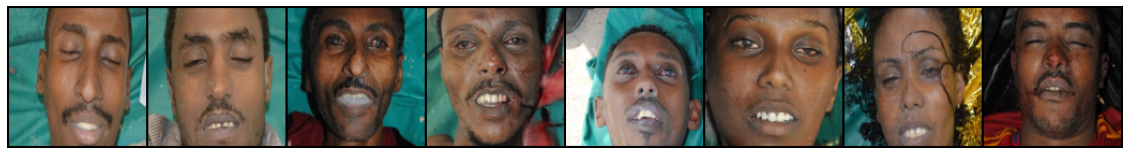

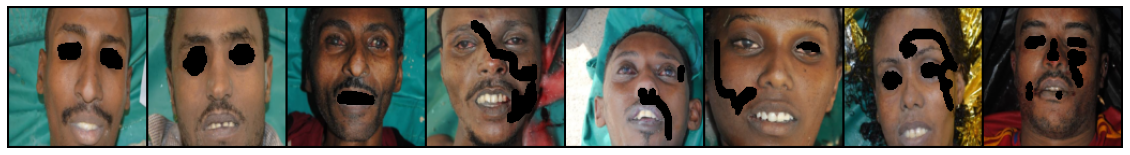

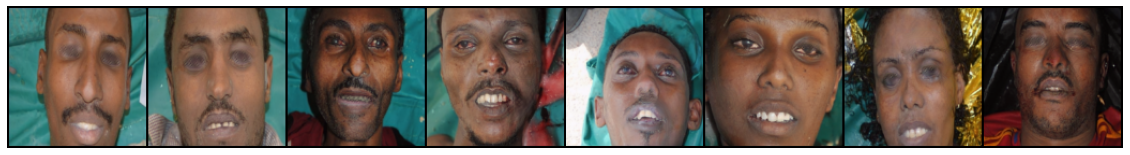

In [5]:
imp.data.testReal(model) # ,segmented=True,keypoints=True

## Super Résolution

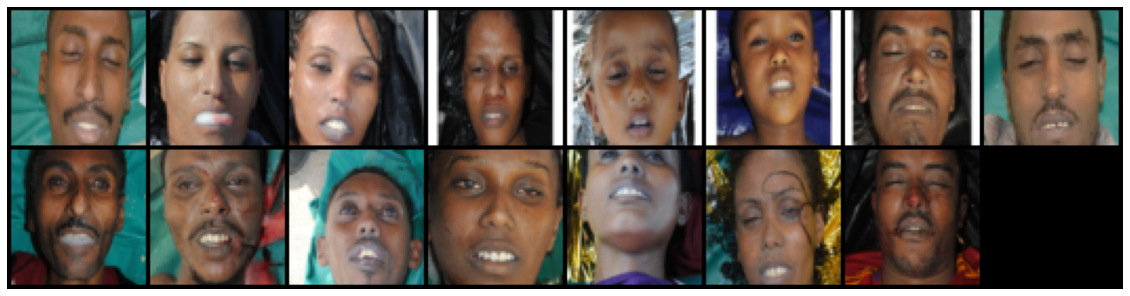

X shape :  torch.Size([15, 3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


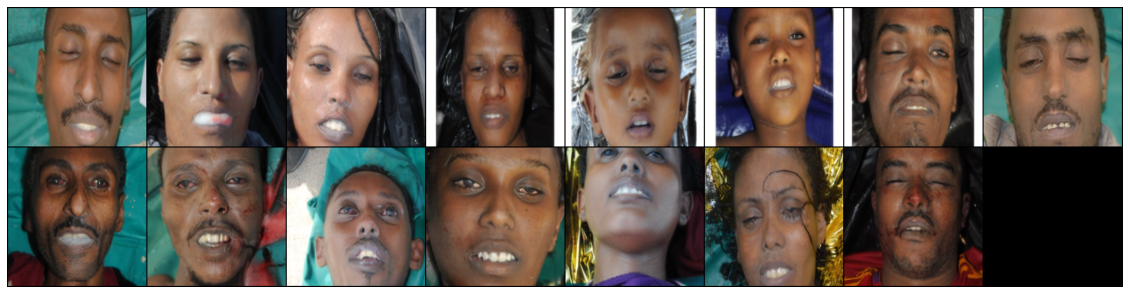

X high res shape :  torch.Size([15, 3, 64, 64])


In [2]:
import impaintingLib as imp 
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = imp.data.getTestImages("./data/real").to(device)
imp.utils.plot_img(x)
print("X shape : ",x.shape)

x_highres = imp.components.superRes(x)
imp.utils.plot_img(x_highres)
print("X high res shape : ",x.shape)